In [1]:

#***************************************************************************
#* 
#* Description: label propagation
#* Author: Zou Xiaoyi (zouxy09@qq.com)
#* Date:   2015-10-15
#* HomePage: http://blog.csdn.net/zouxy09
#* 
#**************************************************************************

import time
import numpy as np

# return k neighbors index
def navie_knn(dataSet, query, k):
    numSamples = dataSet.shape[0]

    ## step 1: calculate Euclidean distance
    diff = np.tile(query, (numSamples, 1)) - dataSet
    squaredDiff = diff ** 2
    squaredDist = np.sum(squaredDiff, axis = 1) # sum is performed by row

    ## step 2: sort the distance
    sortedDistIndices = np.argsort(squaredDist)
    if k > len(sortedDistIndices):
        k = len(sortedDistIndices)

    return sortedDistIndices[0:k]


# build a big graph (normalized weight matrix)
def buildGraph(MatX, kernel_type, rbf_sigma = None, knn_num_neighbors = None):
    num_samples = MatX.shape[0]
    print num_samples
    affinity_matrix = np.zeros((num_samples, num_samples), np.float32)
    if kernel_type == 'rbf':
        if rbf_sigma == None:
            raise ValueError('You should input a sigma of rbf kernel!')
        for i in xrange(num_samples):
            row_sum = 0.0
            for j in xrange(num_samples):
                diff = MatX[i, :] - MatX[j, :]
                affinity_matrix[i][j] = np.exp(sum(diff**2) / (-2.0 * rbf_sigma**2))
                row_sum += affinity_matrix[i][j]
            affinity_matrix[i][:] /= row_sum
    elif kernel_type == 'knn':
        if knn_num_neighbors == None:
            raise ValueError('You should input a k of knn kernel!')
        for i in xrange(num_samples):
            k_neighbors = navie_knn(MatX, MatX[i, :], knn_num_neighbors)
            affinity_matrix[i][k_neighbors] = 1.0 / knn_num_neighbors
    else:
        raise NameError('Not support kernel type! You can use knn or rbf!')
    
    return affinity_matrix


# label propagation
def labelPropagation(Mat_Label, Mat_Unlabel, labels, kernel_type = 'rbf', rbf_sigma = 1.5, \
                    knn_num_neighbors = 10, max_iter = 500, tol = 1e-3):
    # initialize
    num_label_samples = Mat_Label.shape[0]
    num_unlabel_samples = Mat_Unlabel.shape[0]
    num_samples = num_label_samples + num_unlabel_samples
    labels_list = np.unique(labels)
    num_classes = len(labels_list)
    
    MatX = np.vstack((Mat_Label, Mat_Unlabel))
    clamp_data_label = np.zeros((num_label_samples, num_classes), np.float32)
    for i in xrange(num_label_samples):
        clamp_data_label[i][labels[i]] = 1.0
    
    label_function = np.zeros((num_samples, num_classes), np.float32)
    label_function[0 : num_label_samples] = clamp_data_label
    label_function[num_label_samples : num_samples] = -1
    
    # graph construction
    affinity_matrix = buildGraph(MatX, kernel_type, rbf_sigma, knn_num_neighbors)
    
    # start to propagation
    iter = 0; pre_label_function = np.zeros((num_samples, num_classes), np.float32)
    changed = np.abs(pre_label_function - label_function).sum()
    while iter < max_iter and changed > tol:
        if iter % 1 == 0:
            print "---> Iteration %d/%d, changed: %f" % (iter, max_iter, changed)
        pre_label_function = label_function
        iter += 1
        
        # propagation
        label_function = np.dot(affinity_matrix, label_function)
        
        # clamp
        label_function[0 : num_label_samples] = clamp_data_label
        
        # check converge
        changed = np.abs(pre_label_function - label_function).sum()
    
    # get terminate label of unlabeled data
    unlabel_data_labels = np.zeros(num_unlabel_samples)
    for i in xrange(num_unlabel_samples):
        unlabel_data_labels[i] = np.argmax(label_function[i+num_label_samples])
    
    return unlabel_data_labels

795
---> Iteration 0/400, changed: 5523.000000
---> Iteration 1/400, changed: 52.800377
---> Iteration 2/400, changed: 52.519875
---> Iteration 3/400, changed: 51.628891
---> Iteration 4/400, changed: 50.439964
---> Iteration 5/400, changed: 49.193520
---> Iteration 6/400, changed: 47.976528
---> Iteration 7/400, changed: 46.817142
---> Iteration 8/400, changed: 45.721828
---> Iteration 9/400, changed: 44.689049
---> Iteration 10/400, changed: 43.714142
---> Iteration 11/400, changed: 42.792053
---> Iteration 12/400, changed: 41.917583
---> Iteration 13/400, changed: 41.086090
---> Iteration 14/400, changed: 40.293232
---> Iteration 15/400, changed: 39.535583
---> Iteration 16/400, changed: 38.809803
---> Iteration 17/400, changed: 38.113323
---> Iteration 18/400, changed: 37.443626
---> Iteration 19/400, changed: 36.798721
---> Iteration 20/400, changed: 36.176781
---> Iteration 21/400, changed: 35.576302
---> Iteration 22/400, changed: 34.995827
---> Iteration 23/400, changed: 34.434

---> Iteration 213/400, changed: 7.418634
---> Iteration 214/400, changed: 7.381106
---> Iteration 215/400, changed: 7.343854
---> Iteration 216/400, changed: 7.306896
---> Iteration 217/400, changed: 7.270228
---> Iteration 218/400, changed: 7.233845
---> Iteration 219/400, changed: 7.197735
---> Iteration 220/400, changed: 7.161904
---> Iteration 221/400, changed: 7.126353
---> Iteration 222/400, changed: 7.091061
---> Iteration 223/400, changed: 7.056034
---> Iteration 224/400, changed: 7.021275
---> Iteration 225/400, changed: 6.986787
---> Iteration 226/400, changed: 6.952553
---> Iteration 227/400, changed: 6.918582
---> Iteration 228/400, changed: 6.884863
---> Iteration 229/400, changed: 6.851380
---> Iteration 230/400, changed: 6.818159
---> Iteration 231/400, changed: 6.785185
---> Iteration 232/400, changed: 6.752453
---> Iteration 233/400, changed: 6.719961
---> Iteration 234/400, changed: 6.687709
---> Iteration 235/400, changed: 6.655702
---> Iteration 236/400, changed: 6

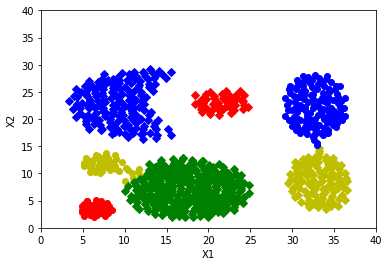

In [2]:
#***************************************************************************
#* 
#* Description: label propagation
#* Author: Zou Xiaoyi (zouxy09@qq.com)
#* Date:   2015-10-15
#* HomePage: http://blog.csdn.net/zouxy09
#* 
#**************************************************************************
import datetime
import time
import math
import numpy as np
import random
#from label_propagation import labelPropagation

# show
def show(Mat_Label, labels, Mat_Unlabel, unlabel_data_labels):
    import matplotlib.pyplot as plt 
    
    color = ['Dr','Db','Dy','Dg','or','ob','oy','og' ]
    
    for i in range(Mat_Label.shape[0]):
        for j in range(len(labels)):
            if int(labels[i]) == labels[j]: 
                plt.plot(Mat_Label[i, 0], Mat_Label[i, 1],color[j])  
    
    for i in range(Mat_Unlabel.shape[0]):
        
        for j in range(len(labels)):
            if int(unlabel_data_labels[i]) == labels[j]: 
                plt.plot(Mat_Unlabel[i, 0], Mat_Unlabel[i, 1],color[j])
            
    plt.xlabel('X1'); plt.ylabel('X2') 
    plt.xlim(0.0, 40.)
    plt.ylim(0.0, 40.)
    plt.show()  


#自定义数据获取函数，从数据集文件获得数据
def loadData():
    filename = 'Aggregation.txt'
    pos = []
    Efield = []
    data = []
    labels = []
    with open(filename, 'r') as file_to_read:
        while True:
            lines = file_to_read.readline() # 整行读取数据
            if not lines:
                break
            pass
            tmp = np.zeros(2, np.float32)
            x, y,l = [float(i) for i in lines.split()] # 将整行数据分割处理，如果分割符是空格，括号里就不用传入参数，如果是逗号， 则传入‘，'字符。
            tmp[0] = x # 添加新读取的数据
            tmp[1] = y
            labels.append(l)
            data.append(tmp)
        pass
        
    pass
    Mat_Label = np.zeros((len(list(set(labels))), 2), np.float32)
    Mat_Label = np.zeros((7, 2), np.float32)
    Mat_Label[0] = [21.9,23.65]
    Mat_Label[1] = [10.6,18.15]
    Mat_Label[2] = [31.2,12]
    Mat_Label[3] = [17,12.9]
    Mat_Label[4] = [5.45,4.85]
    Mat_Label[5] = [33.5,21.3]
    Mat_Label[6] = [9,12.7]
    labels = [0,1,2,3,4,5,6]
    Mat_Unlabel = np.vstack(data)
    return Mat_Label,labels,Mat_Unlabel 

# main function
if __name__ == "__main__":
    num_unlabel_samples = 800
    #Mat_Label, labels, Mat_Unlabel = loadBandData(num_unlabel_samples)
    #Mat_Label, labels, Mat_Unlabel = loadCircleData(num_unlabel_samples)
    starttime = datetime.datetime.now()
    Mat_Label, labels, Mat_Unlabel = loadData()
    ## Notice: when use 'rbf' as our kernel, the choice of hyper parameter 'sigma' is very import! It should be
    ## chose according to your dataset, specific the distance of two data points. I think it should ensure that
    ## each point has about 10 knn or w_i,j is large enough. It also influence the speed of converge. So, may be
    ## 'knn' kernel is better!
    #unlabel_data_labels = labelPropagation(Mat_Label, Mat_Unlabel, labels, kernel_type = 'rbf', rbf_sigma = 0.2)
    unlabel_data_labels = labelPropagation(Mat_Label, Mat_Unlabel, labels, kernel_type = 'knn', knn_num_neighbors = 20, max_iter = 400)
    endtime = datetime.datetime.now()

    print (endtime - starttime)
    %matplotlib inline
    show(Mat_Label, labels, Mat_Unlabel, unlabel_data_labels)
    

In [13]:
#***************************************************************************
#* 
#* Description: label propagation
#* Author: Zou Xiaoyi (zouxy09@qq.com)
#* Date:   2015-10-15
#* HomePage: http://blog.csdn.net/zouxy09
#* 
#**************************************************************************

import os, sys, time
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix, eye
import operator
import cPickle as pickle
import mpi4py.MPI as MPI

#
#   Global variables for MPI
#

# instance for invoking MPI related functions
comm = MPI.COMM_WORLD
# the node rank in the whole community
comm_rank = comm.Get_rank()
# the size of the whole community, i.e., the total number of working nodes in the MPI cluster
comm_size = comm.Get_size()

# load mnist dataset
def load_MNIST():
    '''
    import gzip
    f = gzip.open("mnist.pkl.gz", "rb")
    train, val, test = pickle.load(f)
    f.close()
    
    '''
    filename = 'Aggregation.txt'
    pos = []
    Efield = []
    data = []
    groundtruth = []
    with open(filename, 'r') as file_to_read:
        while True:
            lines = file_to_read.readline() 
            if not lines:
                break
            pass
            tmp = np.zeros(2, np.float32)
            x, y,l = [float(i) for i in lines.split()]
            tmp[0] = x 
            tmp[1] = y
            groundtruth.append(l)
            data.append(tmp)
        pass
        
    pass
    Mat_Label = np.zeros((7, 2), np.float32)
    Mat_Label[0] = [21.9,23.65]
    Mat_Label[1] = [10.6,18.15]
    Mat_Label[2] = [31.2,12]
    Mat_Label[3] = [17,12.9]
    Mat_Label[4] = [5.45,4.85]
    Mat_Label[5] = [33.5,21.3]
    Mat_Label[6] = [9,12.7]
    labels = [0,1,2,3,4,5,6]
    Mat_Unlabel = np.vstack(data)
    
    
    
    
    '''
    Mat_Label = train[0]
    labels = train[1]
    Mat_Unlabel = test[0]
    groundtruth = test[1]
    '''
    labels_id = [0, 1, 2, 3, 4, 5, 6]
    

    return Mat_Label, labels, labels_id, Mat_Unlabel, groundtruth

# return k neighbors index
def navie_knn(dataSet, query, k):
    numSamples = dataSet.shape[0]

    ## step 1: calculate Euclidean distance
    diff = np.tile(query, (numSamples, 1)) - dataSet
    squaredDiff = diff ** 2
    squaredDist = np.sum(squaredDiff, axis = 1) # sum is performed by row

    ## step 2: sort the distance
    sortedDistIndices = np.argsort(squaredDist)
    if k > len(sortedDistIndices):
        k = len(sortedDistIndices)
    return sortedDistIndices[0:k]


# build a big graph (normalized weight matrix)
# sparse U x (U + L) matrix
def buildSubGraph(Mat_Label, Mat_Unlabel, knn_num_neighbors):
    num_unlabel_samples = Mat_Unlabel.shape[0]
    data = []; indices = []; indptr = [0]
    Mat_all = np.vstack((Mat_Label, Mat_Unlabel))
    values = np.ones(knn_num_neighbors, np.float32) / knn_num_neighbors
    for i in xrange(num_unlabel_samples):
        k_neighbors = navie_knn(Mat_all, Mat_Unlabel[i, :], knn_num_neighbors)
        indptr.append(np.int32(indptr[-1]) + knn_num_neighbors)
        indices.extend(k_neighbors)
        data.append(values) 
    return csr_matrix((np.hstack(data), indices, indptr))


# build a big graph (normalized weight matrix)
# sparse U x (U + L) matrix
def buildSubGraph_MPI(Mat_Label, Mat_Unlabel, knn_num_neighbors):
    num_unlabel_samples = Mat_Unlabel.shape[0]
    local_data = []; local_indices = []; local_indptr = [0]
    Mat_all = np.vstack((Mat_Label, Mat_Unlabel))
    values = np.ones(knn_num_neighbors, np.float32) / knn_num_neighbors
    sample_offset = np.linspace(0, num_unlabel_samples, comm_size + 1).astype('int')
    for i in range(sample_offset[comm_rank], sample_offset[comm_rank+1]):
        k_neighbors = navie_knn(Mat_all, Mat_Unlabel[i, :], knn_num_neighbors)
        local_indptr.append(np.int32(local_indptr[-1]) + knn_num_neighbors)
        local_indices.extend(k_neighbors)
        local_data.append(values)
    data = np.hstack(comm.allgather(local_data))
    indices = np.hstack(comm.allgather(local_indices))
    indptr_tmp = comm.allgather(local_indptr)
    indptr = []
    for i in range(len(indptr_tmp)):
        if i == 0:
            indptr.extend(indptr_tmp[i])
        else:
            last_indptr = indptr[-1]
            del(indptr[-1])
            indptr.extend(indptr_tmp[i] + last_indptr)
    return csr_matrix((np.hstack(data), indices, indptr), dtype = np.float32)


# label propagation
def run_label_propagation_sparse(knn_num_neighbors = 20, max_iter = 400, tol = 1e-4, test_per_iter = 1):
    # load data and graph
    print "Processor %d/%d loading graph file..." % (comm_rank, comm_size)
    #Mat_Label, labels, Mat_Unlabel, groundtruth = loadFourBandData()
    Mat_Label, labels, labels_id, Mat_Unlabel, unlabel_data_id = load_MNIST()
    if comm_size > len(labels_id):
        raise ValueError("Sorry, the processors must be less than the number of classes")
    #affinity_matrix = buildSubGraph(Mat_Label, Mat_Unlabel, knn_num_neighbors)
    affinity_matrix = buildSubGraph_MPI(Mat_Label, Mat_Unlabel, knn_num_neighbors)
    
    # get some parameters
    num_classes = len(labels_id)
    num_label_samples = len(labels)
    num_unlabel_samples = Mat_Unlabel.shape[0]

    affinity_matrix_UL = affinity_matrix[:, 0:num_label_samples]
    affinity_matrix_UU = affinity_matrix[:, num_label_samples:num_label_samples+num_unlabel_samples]

    if comm_rank == 0:
        print "Have %d labeled images, %d unlabeled images and %d classes" % (num_label_samples, num_unlabel_samples, num_classes)
    
    # divide label_function_U and label_function_L to all processors
    class_offset = np.linspace(0, num_classes, comm_size + 1).astype('int')
    
    # initialize local label_function_U
    local_start_class = class_offset[comm_rank]
    local_num_classes = class_offset[comm_rank+1] - local_start_class
    local_label_function_U = eye(num_unlabel_samples, local_num_classes, 0, np.float32, format='csr')
    
    # initialize local label_function_L
    local_label_function_L = lil_matrix((num_label_samples, local_num_classes), dtype = np.float32)
    for i in xrange(num_label_samples):
        class_off = int(labels[i]) - local_start_class
        if class_off >= 0 and class_off < local_num_classes:
            local_label_function_L[i, class_off] = 1.0
    local_label_function_L = local_label_function_L.tocsr()
    local_label_info = affinity_matrix_UL.dot(local_label_function_L)
    print "Processor %d/%d has to process %d classes..." % (comm_rank, comm_size, local_label_function_L.shape[1])
    
    # start to propagation
    iter = 1; changed = 100.0;
    evaluation(num_unlabel_samples, local_start_class, local_label_function_U, unlabel_data_id, labels_id)
    while True:
        pre_label_function = local_label_function_U.copy()
        
        # propagation
        local_label_function_U = affinity_matrix_UU.dot(local_label_function_U) + local_label_info
        
        # check converge
        local_changed = abs(pre_label_function - local_label_function_U).sum()
        changed = comm.reduce(local_changed, root = 0, op = MPI.SUM)
        status = 'RUN'
        test = False
        if comm_rank == 0:
            if iter % 1 == 0:
                norm_changed = changed / (num_unlabel_samples * num_classes)
                print "---> Iteration %d/%d, changed: %f" % (iter, max_iter, norm_changed)
            if iter >= max_iter or changed < tol:
                status = 'STOP'
                print "************** Iteration over! ****************"
            if iter % test_per_iter == 0:
                test = True
            iter += 1
        test = comm.bcast(test if comm_rank == 0 else None, root = 0)
        status = comm.bcast(status if comm_rank == 0 else None, root = 0)
        if status == 'STOP':
            break
        if test == True:
            evaluation(num_unlabel_samples, local_start_class, local_label_function_U, unlabel_data_id, labels_id)
    evaluation(num_unlabel_samples, local_start_class, local_label_function_U, unlabel_data_id, labels_id)


def evaluation(num_unlabel_samples, local_start_class, local_label_function_U, unlabel_data_id, labels_id):
    # get local label with max score
    if comm_rank == 0:
        print "Start to combine local result..."
    local_max_score = np.zeros((num_unlabel_samples, 1), np.float32) 
    local_max_label = np.zeros((num_unlabel_samples, 1), np.int32)
    for i in xrange(num_unlabel_samples):
        local_max_label[i, 0] = np.argmax(local_label_function_U.getrow(i).todense())
        local_max_score[i, 0] = local_label_function_U[i, local_max_label[i, 0]]
        local_max_label[i, 0] += local_start_class
        
    # gather the results from all the processors
    if comm_rank == 0:
        print "Start to gather results from all processors"
    all_max_label = np.hstack(comm.allgather(local_max_label))
    all_max_score = np.hstack(comm.allgather(local_max_score))
    
    # get terminate label of unlabeled data
    if comm_rank == 0:
        print "Start to analysis the results..."
        right_predict_count = 0
        for i in xrange(num_unlabel_samples):
            if i % 1000 == 0:
                print "***", all_max_score[i]
            max_idx = np.argmax(all_max_score[i])
            max_label = all_max_label[i, max_idx]
            if int(unlabel_data_id[i]) == int(labels_id[max_label]):
                right_predict_count += 1
        accuracy = float(right_predict_count) * 100.0 / num_unlabel_samples
        print "Have %d samples, accuracy: %.3f%%!" % (num_unlabel_samples, accuracy)


if __name__ == '__main__':
    starttime = datetime.datetime.now()
    run_label_propagation_sparse(knn_num_neighbors = 20, max_iter = 400)
    endtime = datetime.datetime.now()

    print (endtime - starttime)
    

Processor 0/1 loading graph file...
Have 7 labeled images, 788 unlabeled images and 7 classes
Processor 0/1 has to process 7 classes...
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [1.]
Have 788 samples, accuracy: 0.127%!
---> Iteration 1/400, changed: 0.003182
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.05]
Have 788 samples, accuracy: 0.254%!
---> Iteration 2/400, changed: 0.001715
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.0425]
Have 788 samples, accuracy: 0.000%!
---> Iteration 3/400, changed: 0.001347
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.03325]
Have 788 samples, accuracy: 0.127%!
---> Iteration 4/400, changed: 0.001252
Start to combine local result...
Start to gather results from all process

Start to gather results from all processors
Start to analysis the results...
*** [0.06291009]
Have 788 samples, accuracy: 0.127%!
---> Iteration 41/400, changed: 0.000607
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.06595135]
Have 788 samples, accuracy: 0.127%!
---> Iteration 42/400, changed: 0.000599
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.06903188]
Have 788 samples, accuracy: 0.127%!
---> Iteration 43/400, changed: 0.000592
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.07214884]
Have 788 samples, accuracy: 0.127%!
---> Iteration 44/400, changed: 0.000584
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.07529959]
Have 788 samples, accuracy: 0.127%!
---> Iteration 45/400, changed: 0.000577
Start to comb

Start to gather results from all processors
Start to analysis the results...
*** [0.1998747]
Have 788 samples, accuracy: 0.000%!
---> Iteration 82/400, changed: 0.000393
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.2032032]
Have 788 samples, accuracy: 0.000%!
---> Iteration 83/400, changed: 0.000390
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.20652239]
Have 788 samples, accuracy: 0.000%!
---> Iteration 84/400, changed: 0.000386
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.209832]
Have 788 samples, accuracy: 0.000%!
---> Iteration 85/400, changed: 0.000383
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.21313182]
Have 788 samples, accuracy: 0.000%!
---> Iteration 86/400, changed: 0.000380
Start to combine 

Start to gather results from all processors
Start to analysis the results...
*** [0.33292952]
Have 788 samples, accuracy: 0.000%!
---> Iteration 125/400, changed: 0.000282
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.335762]
Have 788 samples, accuracy: 0.000%!
---> Iteration 126/400, changed: 0.000280
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.33858258]
Have 788 samples, accuracy: 0.000%!
---> Iteration 127/400, changed: 0.000278
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.3413914]
Have 788 samples, accuracy: 0.000%!
---> Iteration 128/400, changed: 0.000276
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.34418827]
Have 788 samples, accuracy: 0.000%!
---> Iteration 129/400, changed: 0.000274
Start to co

Start to gather results from all processors
Start to analysis the results...
*** [0.43969578]
Have 788 samples, accuracy: 0.000%!
---> Iteration 166/400, changed: 0.000217
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.44207165]
Have 788 samples, accuracy: 0.000%!
---> Iteration 167/400, changed: 0.000216
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.4444373]
Have 788 samples, accuracy: 0.000%!
---> Iteration 168/400, changed: 0.000215
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.44679275]
Have 788 samples, accuracy: 0.000%!
---> Iteration 169/400, changed: 0.000214
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.44913793]
Have 788 samples, accuracy: 0.000%!
---> Iteration 170/400, changed: 0.000212
Start to 

Start to gather results from all processors
Start to analysis the results...
*** [0.5311287]
Have 788 samples, accuracy: 0.000%!
---> Iteration 208/400, changed: 0.000173
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.5331091]
Have 788 samples, accuracy: 0.000%!
---> Iteration 209/400, changed: 0.000172
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.5350811]
Have 788 samples, accuracy: 0.000%!
---> Iteration 210/400, changed: 0.000171
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.5370445]
Have 788 samples, accuracy: 0.000%!
---> Iteration 211/400, changed: 0.000170
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.5389994]
Have 788 samples, accuracy: 0.000%!
---> Iteration 212/400, changed: 0.000169
Start to comb

Start to gather results from all processors
Start to analysis the results...
*** [0.60733783]
Have 788 samples, accuracy: 0.000%!
---> Iteration 250/400, changed: 0.000141
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.6089885]
Have 788 samples, accuracy: 0.000%!
---> Iteration 251/400, changed: 0.000140
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.61063206]
Have 788 samples, accuracy: 0.000%!
---> Iteration 252/400, changed: 0.000139
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.6122684]
Have 788 samples, accuracy: 0.000%!
---> Iteration 253/400, changed: 0.000139
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.61389774]
Have 788 samples, accuracy: 0.000%!
---> Iteration 254/400, changed: 0.000138
Start to c

Start to gather results from all processors
Start to analysis the results...
*** [0.67085385]
Have 788 samples, accuracy: 0.000%!
---> Iteration 292/400, changed: 0.000117
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.67222965]
Have 788 samples, accuracy: 0.000%!
---> Iteration 293/400, changed: 0.000117
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.67359936]
Have 788 samples, accuracy: 0.000%!
---> Iteration 294/400, changed: 0.000116
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.6749632]
Have 788 samples, accuracy: 0.000%!
---> Iteration 295/400, changed: 0.000116
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.67632115]
Have 788 samples, accuracy: 0.000%!
---> Iteration 296/400, changed: 0.000115
Start to 

Start to gather results from all processors
Start to analysis the results...
*** [0.7237906]
Have 788 samples, accuracy: 0.000%!
---> Iteration 334/400, changed: 0.000099
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.72493714]
Have 788 samples, accuracy: 0.000%!
---> Iteration 335/400, changed: 0.000099
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.7260787]
Have 788 samples, accuracy: 0.000%!
---> Iteration 336/400, changed: 0.000098
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.72721535]
Have 788 samples, accuracy: 0.000%!
---> Iteration 337/400, changed: 0.000098
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.72834706]
Have 788 samples, accuracy: 0.000%!
---> Iteration 338/400, changed: 0.000097
Start to c

Start to gather results from all processors
Start to analysis the results...
*** [0.76695]
Have 788 samples, accuracy: 0.000%!
---> Iteration 375/400, changed: 0.000085
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.7679098]
Have 788 samples, accuracy: 0.000%!
---> Iteration 376/400, changed: 0.000085
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.7688654]
Have 788 samples, accuracy: 0.000%!
---> Iteration 377/400, changed: 0.000084
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.7698169]
Have 788 samples, accuracy: 0.000%!
---> Iteration 378/400, changed: 0.000084
Start to combine local result...
Start to gather results from all processors
Start to analysis the results...
*** [0.770764]
Have 788 samples, accuracy: 0.000%!
---> Iteration 379/400, changed: 0.000084
Start to combine

# 做全新的，不能照抄源码，多核比单核还慢

In [119]:
#***************************************************************************
#* 
#* Description: label propagation
#* Author: Zou Xiaoyi (zouxy09@qq.com)
#* Date:   2015-10-15
#* HomePage: http://blog.csdn.net/zouxy09
#* 
#**************************************************************************

import os, sys, time
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix, eye
import operator
import cPickle as pickle
import mpi4py.MPI as MPI

#
#   Global variables for MPI
#

# instance for invoking MPI related functions
comm = MPI.COMM_WORLD
# the node rank in the whole community
comm_rank = comm.Get_rank()
# the size of the whole community, i.e., the total number of working nodes in the MPI cluster
comm_size = comm.Get_size()

# load mnist dataset
def load_MNIST():
    '''
    import gzip
    f = gzip.open("mnist.pkl.gz", "rb")
    train, val, test = pickle.load(f)
    f.close()
    
    '''
    filename = 'Aggregation.txt'
    pos = []
    Efield = []
    data = []
    groundtruth = []
    with open(filename, 'r') as file_to_read:
        while True:
            lines = file_to_read.readline() # 整行读取数据
            if not lines:
                break
            pass
            tmp = np.zeros(2, np.float32)
            x, y,l = [float(i) for i in lines.split()] # 将整行数据分割处理，如果分割符是空格，括号里就不用传入参数，如果是逗号， 则传入‘，'字符。
            tmp[0] = x # 添加新读取的数据
            tmp[1] = y
            groundtruth.append(l)
            data.append(tmp)
        pass
        
    pass
    Mat_Label = np.zeros((7, 2), np.float32)
    
    Mat_Label[0] = [21.9,23.65]
    Mat_Label[1] = [10.6,18.15]
    Mat_Label[2] = [31.2,12]
    Mat_Label[3] = [17,12.9]
    Mat_Label[4] = [5.45,4.85]
    Mat_Label[5] = [33.5,21.3]
    Mat_Label[6] = [9,12.7]
    labels = [0,1,2,3,4,5,6]
    Mat_Unlabel = np.vstack(data)
    
    
    
    
    '''
    Mat_Label = train[0]
    labels = train[1]
    Mat_Unlabel = test[0]
    groundtruth = test[1]
    '''
    labels_id = [0, 1, 2, 3, 4, 5, 6]
    

    return Mat_Label, labels, labels_id, Mat_Unlabel, groundtruth


In [120]:
def navie_knn(dataSet, query, k):
    numSamples = dataSet.shape[0]

    ## step 1: calculate Euclidean distance
    diff = np.tile(query, (numSamples, 1)) - dataSet
    squaredDiff = diff ** 2
    squaredDist = np.sum(squaredDiff, axis = 1) # sum is performed by row

    ## step 2: sort the distance
    sortedDistIndices = np.argsort(squaredDist)
    if k > len(sortedDistIndices):
        k = len(sortedDistIndices)

    return sortedDistIndices[0:k]

In [4]:
print comm_size

1


In [ ]:
import mpi4py.MPI as MPI  
   
comm = MPI.COMM_WORLD  
comm_rank = comm.Get_rank()  
comm_size = comm.Get_size()  
   
data_send = [comm_rank]*5  
if comm_rank == 0:  
   comm.send(data_send, dest=(comm_rank+1)%comm_size)  
if comm_rank > 0:  
   data_recv = comm.recv(source=(comm_rank-1)%comm_size)  
   comm.send(data_send, dest=(comm_rank+1)%comm_size)  
if comm_rank == 0:  
   data_recv = comm.recv(source=(comm_rank-1)%comm_size)  
print("my rank is %d, and Ireceived:" % comm_rank)  
print data_recv

In [14]:
from mpi4py import MPI  
comm = MPI.COMM_WORLD  
comm_rank = comm.Get_rank()  
comm_size = comm.Get_size()  

print comm_size

1
